In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import keras
from sklearn.manifold import TSNE
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn import preprocessing 
import itertools


Using TensorFlow backend.


In [0]:
data=pd.read_csv('/content/drive/My Drive/creditcard.csv')
#data["Time"] = data["Time"].apply(lambda x : x / 3600 % 24)

In [0]:
non_fraud = data[data['Class'] == 0]
fraud = data[data['Class'] == 1]
data = data.sample(frac=1).reset_index(drop=True)


In [0]:
X = data.drop(['Class','Time'], axis = 1).values
Y = data["Class"].values

In [0]:
#nature of representations can be learned by T-SNE Representation

In [0]:
X_train, X_test, y_train, y_test= train_test_split(X,Y, test_size=0.2,random_state=42)

In [0]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');

    plt.show();
    


In [0]:
non_fraud=X_test[y_test==0]
fraud=X_test[y_test==1]
mod1 = np.append(non_fraud[:3000], fraud, axis = 0)
ha = np.zeros(3000)
lo = np.ones(fraud.shape[0])
mod2 = np.append(ha,lo)

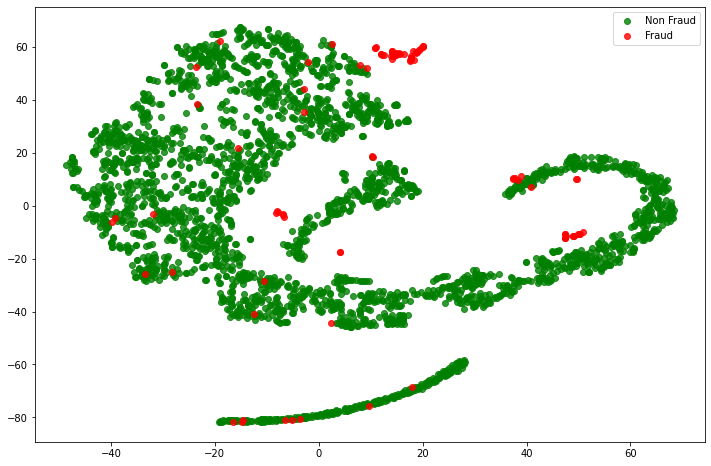

In [0]:
tsne_plot(mod1, mod2, "original.png")

In [0]:
#Autoencoder for latent represenations

input_layer = Input(shape=(X_train.shape[1],))
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
dd1=Dense(75,activation='tanh')(encoded)
dd2=Dense(50,activation='tanh')(dd1)
encoded1= Dense(20, activation='tanh')(dd2)
decoded1= Dense(20, activation='tanh')(encoded1)
dd11=Dense(50,activation='tanh')(decoded1)
dd22=Dense(75,activation='tanh')(dd11)
decoded2=Dense(100, activation='tanh')(dd22)
output_layer = Dense(X_train.shape[1], activation='tanh')(decoded2)


In [0]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adam", loss="mse")

In [0]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 29)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               3000      
_________________________________________________________________
dense_2 (Dense)              (None, 75)                7575      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_5 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1050

In [0]:
scaler=preprocessing.MinMaxScaler()
X_scale = scaler.fit_transform(X_train)
X_train_norm, X_train_fraud = X_scale[y_train == 0], X_scale[y_train == 1]

In [0]:
#Test
X_test_scale = scaler.transform(X_test)
X_test_norm, X_test_fraud = X_test_scale[y_test == 0], X_test_scale[y_test == 1]

In [0]:
autoencoder.fit(X_train_norm, X_train_norm, 
                batch_size = 64, epochs = 10, 
                shuffle = True, validation_split = 0.20);

Train on 181972 samples, validate on 45494 samples
Epoch 1/10
181972/181972 [==============================] - 21s 116us/step - loss: 0.0088 - val_loss: 0.0031
Epoch 2/10
181972/181972 [==============================] - 19s 106us/step - loss: 0.0024 - val_loss: 0.0021
Epoch 3/10
181972/181972 [==============================] - 19s 106us/step - loss: 0.0018 - val_loss: 0.0017
Epoch 4/10
181972/181972 [==============================] - 19s 105us/step - loss: 0.0015 - val_loss: 0.0015
Epoch 5/10
181972/181972 [==============================] - 20s 107us/step - loss: 0.0014 - val_loss: 0.0015
Epoch 6/10
181972/181972 [==============================] - 20s 112us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 7/10
181972/181972 [==============================] - 19s 104us/step - loss: 0.0013 - val_loss: 0.0016
Epoch 8/10
181972/181972 [==============================] - 19s 104us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 9/10
181972/181972 [==============================] - 19s 104us/step - 

In [0]:
#Test Autoencoder
X_Test_norm_pred=autoencoder.predict(X_test_norm)

**Prediction of the latent representations**

In [0]:
latent_representation = Sequential()
latent_representation.add(autoencoder.layers[0])
latent_representation.add(autoencoder.layers[1])
latent_representation.add(autoencoder.layers[2])
latent_representation.add(autoencoder.layers[3])
latent_representation.add(autoencoder.layers[4])

In [0]:
train_norm_hid_rep = latent_representation.predict(X_train_norm)
train_fraud_hid_rep = latent_representation.predict(X_train_fraud)

In [0]:
test_norm_hid_rep=latent_representation.predict(X_test_norm)
test_fraud_hid_rep=latent_representation.predict(X_test_fraud)

In [0]:
rep_x = np.append(train_norm_hid_rep, train_fraud_hid_rep, axis = 0)
y_n = np.zeros(train_norm_hid_rep.shape[0])
y_f = np.ones(train_fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

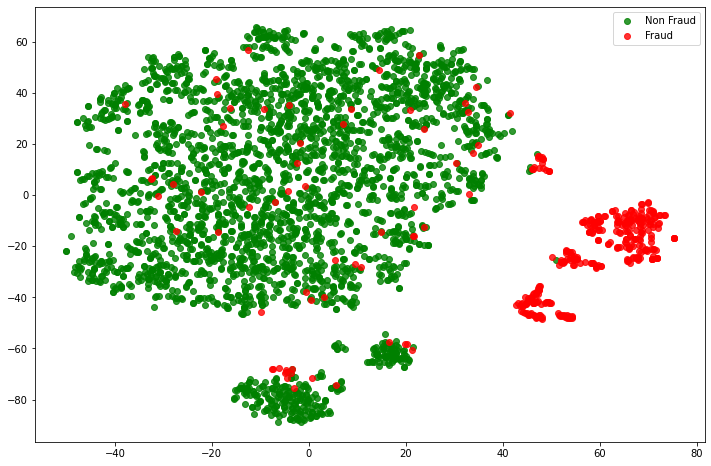

In [0]:
tsne_plot(rep_x, rep_y, "latent_representation.png")

In [0]:
test_rep_x = np.append(test_norm_hid_rep, test_fraud_hid_rep, axis = 0)
test_y_n = np.zeros(test_norm_hid_rep.shape[0])
test_y_f = np.ones(test_fraud_hid_rep.shape[0])
test_rep_y = np.append(test_y_n, test_y_f)

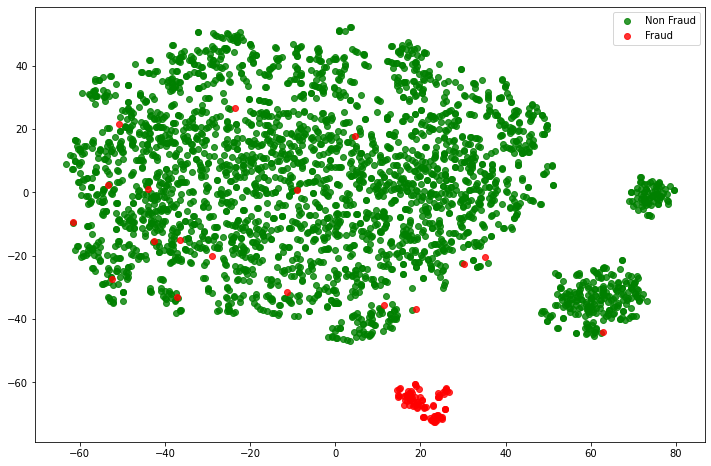

In [0]:
tsne_plot(test_rep_x, test_rep_y, "latent_representation.png")

**Evaluation and results**

1. Evaluation on train data

In [0]:
#Training of linear classifier for classifying latent representations
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
clf=LogisticRegression()
clf1=RandomForestClassifier()
clf1.fit(rep_x,rep_y)
print(classification_report(clf1.predict(rep_x),rep_y))
print ("Accuracy Score: ", accuracy_score(clf1.predict(rep_x), rep_y))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    227466
         1.0       1.00      1.00      1.00       379

    accuracy                           1.00    227845
   macro avg       1.00      1.00      1.00    227845
weighted avg       1.00      1.00      1.00    227845

Accuracy Score:  1.0


2. Evaluation on test data

In [0]:
test_rep_x_pred=clf1.predict(test_rep_x)

In [0]:
print(classification_report(clf1.predict(test_rep_x),test_rep_y))
print ("Accuracy Score: ", accuracy_score(clf1.predict(test_rep_x), test_rep_y))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56864
         1.0       0.81      0.94      0.87        98

    accuracy                           1.00     56962
   macro avg       0.91      0.97      0.94     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy Score:  0.9995259997893332


In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall metric in the testing dataset:  0.9390243902439024


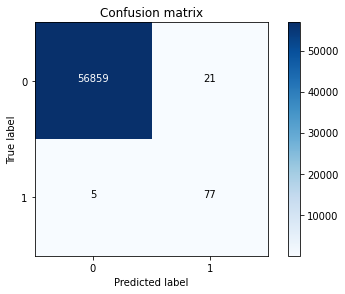

In [0]:
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve,recall_score,auc,accuracy_score
cnf_matrix = confusion_matrix(test_rep_x_pred,test_rep_y)
np.set_printoptions(precision=2)
print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

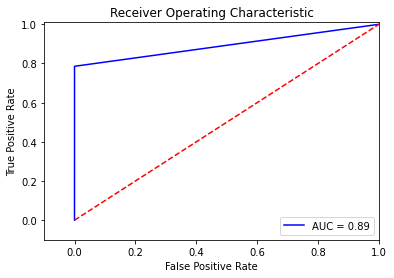

In [0]:
fpr, tpr, thresholds = roc_curve(test_rep_y,test_rep_x_pred)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()